<a href="https://colab.research.google.com/github/abdullahamruf/Mosquito/blob/main/mosquito_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tensorflow import keras
import glob as gb
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D ,LeakyReLU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMG_SIZE = (299, 299) # resolution
directory = "/content/drive/MyDrive/zw4p9kj6nt-2"
BATCH_SIZE = 32
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.1,
                                             subset='training',
                                             color_mode='rgb',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.1,
                                             subset='validation',
                                             color_mode='rgb',
                                             seed=42)

Found 1500 files belonging to 6 classes.
Using 1350 files for training.
Found 1500 files belonging to 6 classes.
Using 150 files for validation.


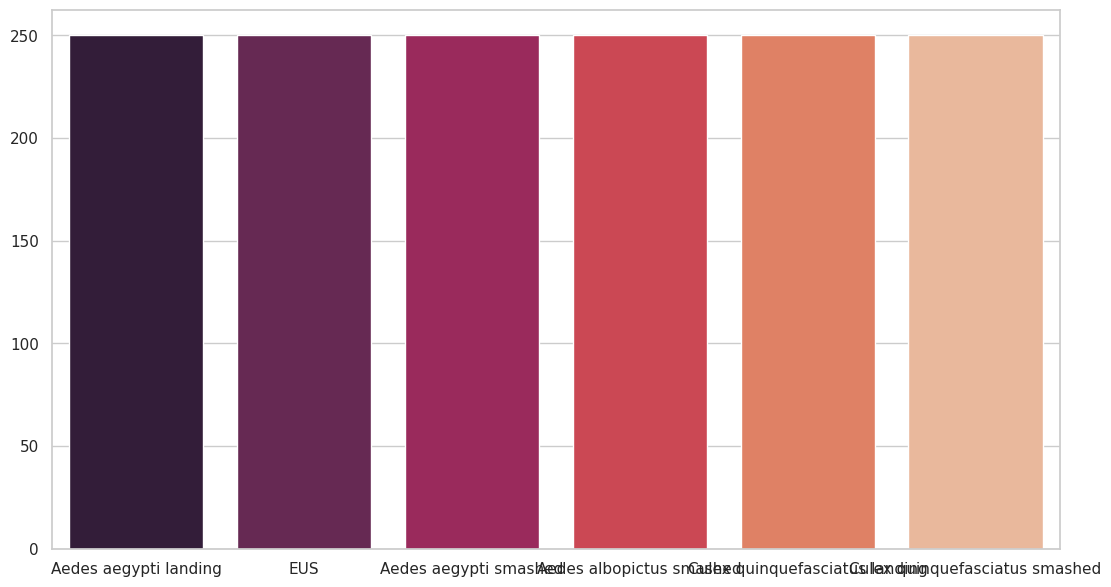

In [ ]:
sns.set_theme(style="whitegrid")
Data_imbalance = []
for folder in os.listdir(directory):
    files = gb.glob(pathname=str(directory + "/" + folder +"/*.*"))
    Data_imbalance.append(len(files))
plt.figure(figsize=(13,7))
sns.barplot(x=[ "Aedes aegypti landing", "EUS", "Aedes aegypti smashed","Aedes albopictus smashed","Culex quinquefasciatus landing","Culex quinquefasciatus smashed"], y=Data_imbalance, palette="rocket")
plt.show()

In [ ]:
total = 0
for i in range(0,len(Data_imbalance)) :
    total +=Data_imbalance[i]

weight_for_0 = (1 / Data_imbalance[0]) * (total / 6.0)
weight_for_1 = (1 / Data_imbalance[1]) * (total / 6.0)
weight_for_2 = (1 / Data_imbalance[2]) * (total / 6.0)
weight_for_3 = (1 / Data_imbalance[3]) * (total / 6.0)
weight_for_4 = (1 / Data_imbalance[3]) * (total / 6.0)
weight_for_5 = (1 / Data_imbalance[3]) * (total / 6.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3,4: weight_for_4,5: weight_for_5}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))
print('Weight for class 4: {:.2f}'.format(weight_for_4))
print('Weight for class 5: {:.2f}'.format(weight_for_5))


Weight for class 0: 1.00
Weight for class 1: 1.00
Weight for class 2: 1.00
Weight for class 3: 1.00
Weight for class 4: 1.00
Weight for class 5: 1.00


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])

In [ ]:
augmented_count = 0

for image, _ in train_dataset:
    augmented_images = data_augmentation(image)
    augmented_count += augmented_images.shape[0]  # Count the number of augmented images

original_count = len(train_dataset) * BATCH_SIZE  # Total number of original images
total_count = original_count + augmented_count    # Total number of images after augmentation

increase_percentage = ((total_count - original_count) / original_count) * 100

print(f"Original image count: {original_count}")
print(f"Augmented image count: {augmented_count}")
print(f"Total image count after augmentation: {total_count}")
print(f"Increase in image count: {increase_percentage:.2f}%")


Original image count: 1376
Augmented image count: 1350
Total image count after augmentation: 2726
Increase in image count: 98.11%


In [ ]:
IMG_SHAPE = IMG_SIZE +(3,)
base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE, include_top= False, weights='imagenet')

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
type(base_model)
preprocess_input = tf.keras.applications.densenet.preprocess_input

In [ ]:
nb_layers = len(base_model.layers)
print("Numbers of Layers =" , nb_layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name)

Numbers of Layers = 427
bn
relu


In [ ]:
# iterate over first batch (32 image) in trainset
image_batch, label_batch = next(iter(train_dataset))  # 32 image arrays
feature_batch = base_model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes

(32, 9, 9, 1024)


In [ ]:
def dense( image_shape=IMG_SIZE):
    ''' Define a tf.keras model for multi-class classification out of the InceptionV3 model '''
    image_shape = image_shape + (3,)

    resnet_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')
    resnet_model.trainable = True
    for layer in resnet_model.layers[0 : 291]:
        layer.trainable = False

    inputs = tf.keras.Input(image_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = resnet_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    prediction_layer = tf.keras.layers.Dense(7 ,activation = "softmax")
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    model.summary()
    return model

In [ ]:
dense = dense(IMG_SIZE)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 299, 299, 3)       0         
 a)                                                              
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 299, 299, 3)       0         
 )                                                               
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 299, 299, 3)       0         
 bda)                                                            
                                                                 
 densenet121 (Functional)    (None, 9, 9, 1024)        7037504   
                                                             

In [ ]:
base_learning_rate = 0.001
dense.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
base_learning_rate = 0.001
dense.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=['accuracy'])

In [ ]:
model_filepath="/content/drive/MyDrive/densemosquito-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath = model_filepath ,
    monitor ='val_accuracy',
    mode = 'max' ,
    save_best_only =True ,
     verbose = 1

)

In [ ]:
history = dense.fit(train_dataset , verbose=2 , epochs=5 ,class_weight=class_weight,
                               validation_data=validation_dataset , use_multiprocessing= True ,callbacks =[checkpoint])

Epoch 1/5

Epoch 1: val_accuracy improved from -inf to 0.68000, saving model to /content/drive/MyDrive/densemosquito-01-0.6800.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 - 695s - loss: 1.3716 - accuracy: 0.4689 - val_loss: 0.7898 - val_accuracy: 0.6800 - 695s/epoch - 16s/step
Epoch 2/5

Epoch 2: val_accuracy did not improve from 0.68000
43/43 - 644s - loss: 0.5568 - accuracy: 0.7926 - val_loss: 3.7577 - val_accuracy: 0.4933 - 644s/epoch - 15s/step
Epoch 3/5

Epoch 3: val_accuracy improved from 0.68000 to 0.84000, saving model to /content/drive/MyDrive/densemosquito-03-0.8400.hdf5
43/43 - 644s - loss: 0.7320 - accuracy: 0.7504 - val_loss: 0.3992 - val_accuracy: 0.8400 - 644s/epoch - 15s/step
Epoch 4/5

Epoch 4: val_accuracy did not improve from 0.84000
43/43 - 632s - loss: 0.2983 - accuracy: 0.8911 - val_loss: 1.2596 - val_accuracy: 0.6533 - 632s/epoch - 15s/step
Epoch 5/5

Epoch 5: val_accuracy improved from 0.84000 to 0.88000, saving model to /content/drive/MyDrive/densemosquito-05-0.8800.hdf5
43/43 - 653s - loss: 0.2637 - accuracy: 0.9148 - val_loss: 0.3938 - val_accuracy: 0.8800 - 653s/epoch - 15s/step


In [ ]:
dense.evaluate(validation_dataset , verbose = 1)

5/5 [==============================] - 52s 10s/step - loss: 0.3938 - accuracy: 0.8800


[0.3937675952911377, 0.8799999952316284]

In [ ]:
class_names = train_dataset.class_names
class_names

['Aedes  albopictus landing',
 'Aedes aegypti landing',
 'Aedes aegypti smashed',
 'Aedes albopictus smashed',
 'Culex quinquefasciatus landing',
 'Culex quinquefasciatus smashed']

1/1 [==============================] - 0s 267ms/step


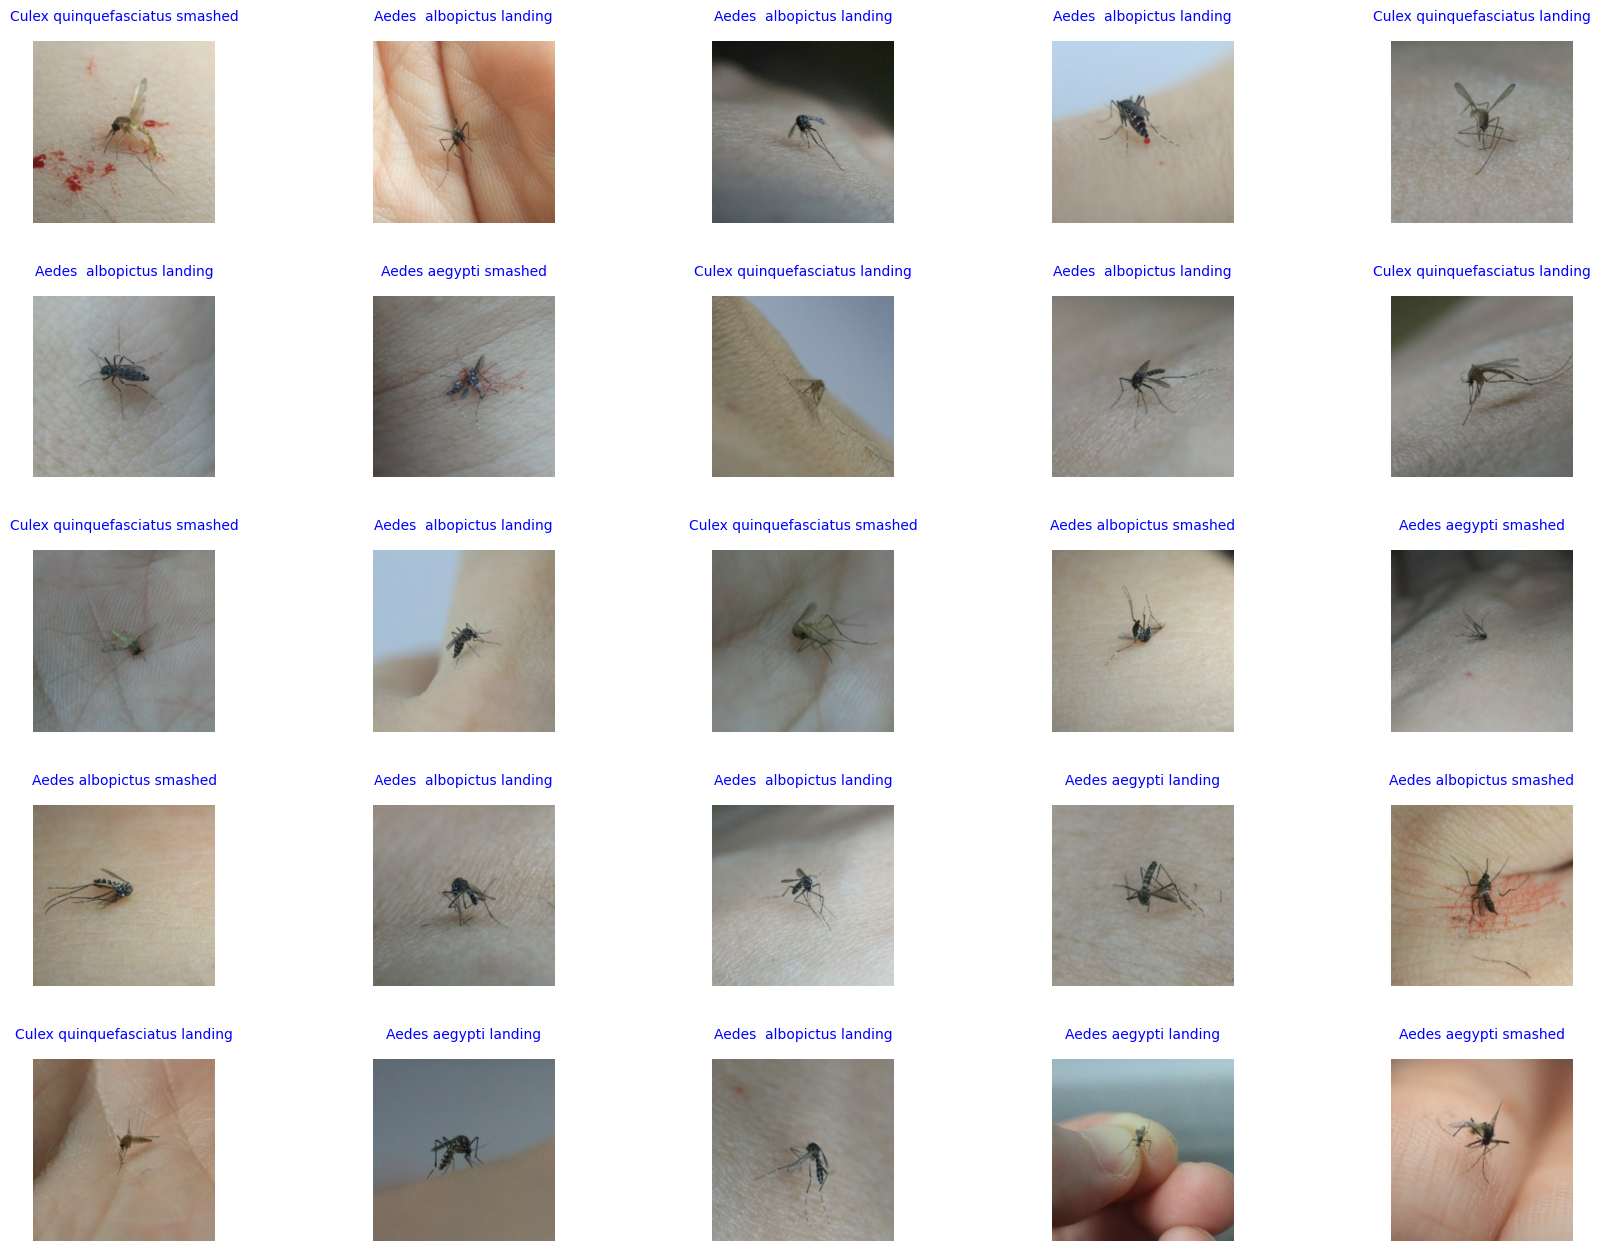

In [ ]:
plt.figure(figsize=(20, 15))
for images, labels in train_dataset.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)
        predict = dense.predict(img2)
        predicted= class_names[np.argmax(predict)]
        actual = class_names [labels[i].numpy().astype("uint8")]
        if (actual == predicted):
            plt.title(predicted, fontsize=10, color= 'blue', pad=15);
        else :
            plt.title(actual, fontsize=10, color= 'red' ,pad=15);
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9,
                            top=0.9, wspace=0.4,hspace=0.4)

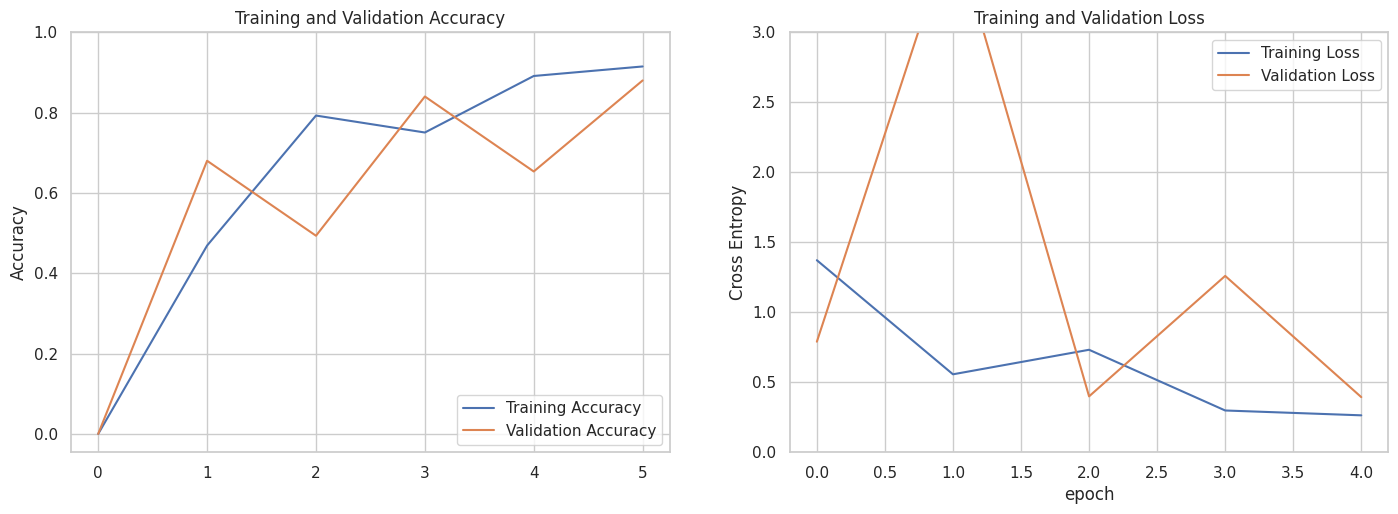

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset and make predictions
for images, labels in validation_dataset:
    predictions = dense.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(report)


1/1 [==============================] - 10s 10s/step
                                precision    recall  f1-score   support

     Aedes  albopictus landing       0.96      0.88      0.92        25
         Aedes aegypti landing       0.87      0.80      0.83        25
         Aedes aegypti smashed       0.79      0.65      0.71        23
      Aedes albopictus smashed       0.79      0.96      0.87        27
Culex quinquefasciatus landing       0.93      0.97      0.95        29
Culex quinquefasciatus smashed       0.95      1.00      0.98        21

                      accuracy                           0.88       150
                     macro avg       0.88      0.88      0.88       150
                  weighted avg       0.88      0.88      0.88       150



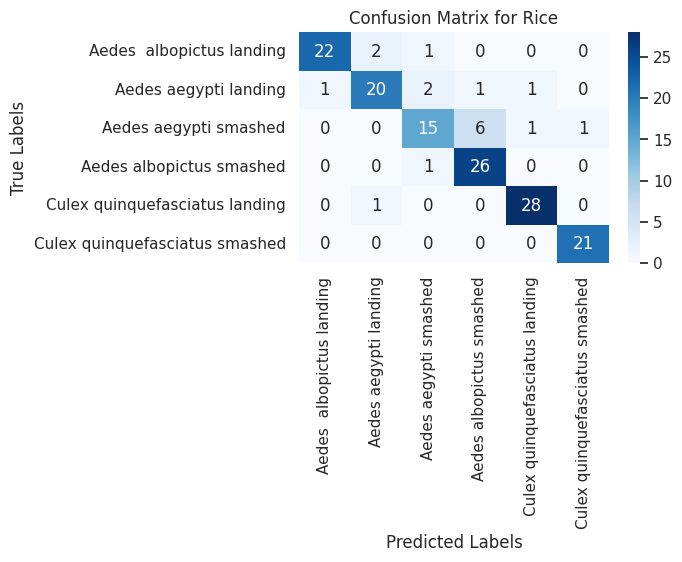

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Rice')
plt.show()